In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)
from codecarbon import EmissionsTracker
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv(r"C:\Users\User\Desktop\ML SDS\Austin Fire Project\AFD_Fire_Incidents_2022-2024_20250930.csv")

In [6]:
print(df.head())

   Incident Number  CalendarYear Month                 IncDate Call_Type  \
0         22000002          2022   Jan  01/01/2022 12:00:00 AM      Fire   
1         22000011          2022   Jan  01/01/2022 12:00:00 AM      Fire   
2         22000019          2022   Jan  01/01/2022 12:00:00 AM      Fire   
3         22000028          2022   Jan  01/01/2022 12:00:00 AM      Fire   
4         22000029          2022   Jan  01/01/2022 12:00:00 AM      Fire   

                    Problem ResponseArea Jurisdiction PriorityDescription  \
0  GRASS - Small Grass Fire      00-2403          AFD                  3F   
1        TRASH - Trash Fire      00-3004          AFD                  3F   
2        TRASH - Trash Fire      00-0603          AFD                  3F   
3      DUMP - Dumpster Fire      00-3404          AFD                  3F   
4      DUMP - Dumpster Fire      00-5101          AFD                  3F   

  Council_District                Location  
0                2  (-97.769871,30.

Target Variable: Priority Description (In Binary)

1 = high priority (1F, 2F)
0 = low priority (3F, 4F)

In [ ]:
#Target Variable: Priority Description (In Binary)
df = df[df["PriorityDescription"].notna()]
df["Priority_Level"] = df["PriorityDescription"].apply(lambda x: 1 if str(x).startswith(("1F", "2F")) else 0)

In [10]:
# Input Features
features = ["Call_Type", "Problem", "Council_District", "Jurisdiction", "Month", "ResponseArea"]
df_model = df[features + ["Priority_Level"]].dropna()

In [11]:
#encode categorical variables
le_dict = {}
for col in features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    le_dict[col] = le

X = df_model[features]
y = df_model["Priority_Level"]

In [12]:
#train test split + Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (14635, 6) Test shape: (6273, 6)


#MODEL CHOICES AND JUSTIFICATION

Logistic Regression = interpretable baseline





Decision Tree = flexible, captures nonlinear relationships

In [14]:
#Hyperparameter tuning + loss function

log_reg = LogisticRegression(max_iter=1000)
param_grid_lr = {"C": [0.01, 0.1, 1, 10, 100]}
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring="f1")
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
print("Best Logistic Regression Params:", grid_lr.best_params_)

Best Logistic Regression Params: {'C': 0.1}


In [15]:
#Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {"max_depth": [3, 5, 7, 9, 12], "min_samples_split": [2, 5, 10]}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring="f1")
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
print("Best Decision Tree Params:", grid_dt.best_params_)

Best Decision Tree Params: {'max_depth': 7, 'min_samples_split': 2}


Evaluation and Validation


📊 Model Evaluation: Logistic Regression
Accuracy: 0.908
Precision: 0.885
Recall: 0.755
F1 Score: 0.815
ROC-AUC: 0.977


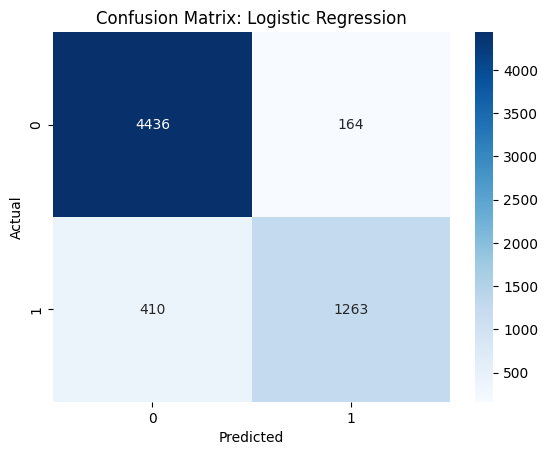


📊 Model Evaluation: Decision Tree
Accuracy: 1.0
Precision: 1.0
Recall: 0.999
F1 Score: 1.0
ROC-AUC: 1.0


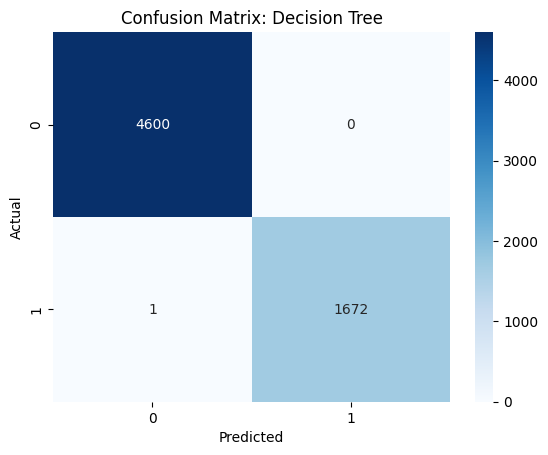

In [16]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    print(f"\n📊 Model Evaluation: {name}")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))
    print("F1 Score:", round(f1_score(y_test, y_pred), 3))
    if y_prob is not None:
        print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(best_lr, X_train, y_train, X_test, y_test, "Logistic Regression")
evaluate_model(best_dt, X_train, y_train, X_test, y_test, "Decision Tree")

In [17]:
#Energy Usage Analysis (sustainability aspect)
# We’ll estimate training + prediction emissions per 1,000 predictions.

tracker = EmissionsTracker(project_name="AFD_Priority_Classifier")

tracker.start()
best_lr.fit(X_train, y_train)
lr_emissions = tracker.stop()

tracker.start()
best_dt.fit(X_train, y_train)
dt_emissions = tracker.stop()

# Simulate prediction for 1,000 samples
sample_X = X_test.sample(1000, replace=True, random_state=42)
tracker.start()
_ = best_lr.predict(sample_X)
lr_pred_emissions = tracker.stop()

tracker.start()
_ = best_dt.predict(sample_X)
dt_pred_emissions = tracker.stop()

print("\n🌱 ENERGY CONSUMPTION SUMMARY")
print(f"Logistic Regression (Train): {lr_emissions:.6f} kg CO2e")
print(f"Decision Tree (Train): {dt_emissions:.6f} kg CO2e")
print(f"Logistic Regression (1000 Predictions): {lr_pred_emissions:.6f} kg CO2e")
print(f"Decision Tree (1000 Predictions): {dt_pred_emissions:.6f} kg CO2e")

[codecarbon WARNING @ 09:16:09] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 09:16:09] [setup] RAM Tracking...
[codecarbon INFO @ 09:16:09] [setup] CPU Tracking...
[codecarbon WARNING @ 09:16:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 09:16:10] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-1360P
[codecarbon WARNING @ 09:16:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:16:10] [setup] GPU Tracking...
[codecarbon INFO @ 09:16:10] No GPU found.
[codecarbon INFO @ 09:16:10] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 09:16:10] >>> Tracker's metadata:
[codecar


🌱 ENERGY CONSUMPTION SUMMARY
Logistic Regression (Train): 0.000001 kg CO2e
Decision Tree (Train): 0.000002 kg CO2e
Logistic Regression (1000 Predictions): 0.000002 kg CO2e
Decision Tree (1000 Predictions): 0.000003 kg CO2e
